In [457]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from re import sub
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# nltk.download()

In [2]:
cwd = os.getcwd()
source_path = cwd + '/source//'

In [3]:
# load data
calendar = pd.read_csv(source_path + '/calendar.csv')
df_list = pd.read_csv(source_path + '/listings.csv')
listings_detail = pd.read_csv(source_path + '/listings_detail.csv')
#neighbourhoods = pd.read_csv(cwd + '/neighbourhoods.csv')
reviews = pd.read_csv(source_path + '/reviews_detail.csv')

/Users/sharonyan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (43,61,62,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [380]:
# calendar.head()

In [381]:
df_list['neighbourhood'].unique()

array(['朝阳区 / Chaoyang', '密云县 / Miyun', '东城区', '西城区', '海淀区',
       '顺义区 / Shunyi', '怀柔区 / Huairou', '昌平区', '通州区 / Tongzhou',
       '丰台区 / Fengtai', '房山区', '延庆县 / Yanqing', '大兴区 / Daxing', '石景山区',
       '平谷区 / Pinggu', '门头沟区 / Mentougou'], dtype=object)

In [382]:
df_list.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,44054,Modern and Comfortable Living in CBD,192875,East Apartments,NaN,朝阳区 / Chaoyang,39.89503,116.45163,Entire home/apt,812,1,92,2019-06-09,0.85,6,347
1,100213,The Great Wall Box Deluxe Suite A团园长城小院东院套房,527062,Joe,NaN,密云县 / Miyun,40.68434,117.17231,Private room,1197,1,2,2017-10-08,0.09,4,0
2,114384,Newly Remodeled Apt GUOMAO CBD,533062,Helen,NaN,朝阳区 / Chaoyang,39.90491,116.46367,Entire home/apt,667,1,60,2018-02-14,1.08,4,0
3,114465,"GUOMAO, CBD Comfy Convenient Apt",533062,Helen,NaN,朝阳区 / Chaoyang,39.90441,116.46524,Entire home/apt,619,1,9,2017-09-21,0.11,4,365
4,114475,Cozy Apt Central GUOMAO,533062,Helen,NaN,朝阳区 / Chaoyang,39.90555,116.46695,Entire home/apt,619,1,2,2015-09-26,0.04,4,365


In [383]:
listings_detail.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,44054,https://www.airbnb.com/rooms/44054,20190715155043,2019-07-15,Modern and Comfortable Living in CBD,East Apartments offers comfortable living away...,East Apartments is a western managed serviced ...,East Apartments offers comfortable living away...,none,The neighborhood is a private compound. Just ...,...,t,f,strict_14_with_grace_period,f,f,6,6,0,0,0.85
1,100213,https://www.airbnb.com/rooms/100213,20190715155043,2019-07-15,The Great Wall Box Deluxe Suite A团园长城小院东院套房,This is your guide to live by the Great Wall! ...,This is your guide to live by the Great Wall! ...,This is your guide to live by the Great Wall! ...,none,"5 mins walk to Panglongshan Great Wall, 25 min...",...,t,f,strict_14_with_grace_period,f,f,4,0,3,1,0.09
2,114384,https://www.airbnb.com/rooms/114384,20190715155043,2019-07-16,Newly Remodeled Apt GUOMAO CBD,"华纳北京恋日公寓位于北京的中心商务区,是十分受到旅客欢迎的订房选择｡ 5.0 km之外便是市...","Our Suite Apartments, located only 40 km from ...","华纳北京恋日公寓位于北京的中心商务区,是十分受到旅客欢迎的订房选择｡ 5.0 km之外便是市...",none,Numerous eateries and coffee store within 3 mi...,...,t,f,moderate,f,f,4,4,0,0,1.08
3,114465,https://www.airbnb.com/rooms/114465,20190715155043,2019-07-15,"GUOMAO, CBD Comfy Convenient Apt","华纳北京恋日公寓位于北京的中心商务区,是十分受到旅客欢迎的订房选择｡ 5.0 km之外便是市...","Warner Beijing Sun Thirsty Apartment, located ...","华纳北京恋日公寓位于北京的中心商务区,是十分受到旅客欢迎的订房选择｡ 5.0 km之外便是市...",none,The neighborhood is quite safe.,...,t,f,moderate,f,f,4,4,0,0,0.11
4,114475,https://www.airbnb.com/rooms/114475,20190715155043,2019-07-15,Cozy Apt Central GUOMAO,"华纳北京恋日公寓位于北京的中心商务区,是十分受到旅客欢迎的订房选择｡ 5.0 km之外便是市...","Warner Beijing Sun Thirsty Apartment, located ...","华纳北京恋日公寓位于北京的中心商务区,是十分受到旅客欢迎的订房选择｡ 5.0 km之外便是市...",none,The neighborhood is very safe and convenient.,...,t,f,moderate,f,f,4,4,0,0,0.04


In [384]:
list(listings_detail)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


In [385]:
# neighbourhoods

In [386]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,cleaned_comments,is_Chinese
0,44054,84748,2010-08-25,207019,Jarrod,Sev was very helpful. Sev showed us where to ...,Sev was very helpful Sev showed us where to s...,None
1,44054,118384,2010-10-13,218723,Kimberly,We arrived in Beijing very early in the mornin...,We arrived in Beijing very early in the mornin...,None
2,44054,436978,2011-08-11,609177,Emma,It is a really massive apartment and really co...,It is a really massive apartment and really co...,None
3,44054,1118657,2012-04-12,1787536,Andreyna,"Sev was incredibly helpful, showed us around t...",Sev was incredibly helpful showed us around th...,None
4,44054,2140650,2012-08-30,1179565,Frances,The appartment was ideal for our party of 6 ad...,The appartment was ideal for our party of adu...,None


In [387]:
df_list['neighbourhood'].value_counts(normalize=True)

朝阳区 / Chaoyang      0.346208
东城区                 0.110051
海淀区                 0.104584
丰台区 / Fengtai       0.060115
西城区                 0.057585
延庆县 / Yanqing       0.056771
密云县 / Miyun         0.043160
通州区 / Tongzhou      0.041764
顺义区 / Shunyi        0.037110
昌平区                 0.035423
怀柔区 / Huairou       0.033737
大兴区 / Daxing        0.030596
房山区                 0.022481
石景山区                0.008201
门头沟区 / Mentougou    0.006515
平谷区 / Pinggu        0.005700
Name: neighbourhood, dtype: float64

In [388]:
df_list['neighbourhood'].value_counts()

朝阳区 / Chaoyang      11904
东城区                  3784
海淀区                  3596
丰台区 / Fengtai        2067
西城区                  1980
延庆县 / Yanqing        1952
密云县 / Miyun          1484
通州区 / Tongzhou       1436
顺义区 / Shunyi         1276
昌平区                  1218
怀柔区 / Huairou        1160
大兴区 / Daxing         1052
房山区                   773
石景山区                  282
门头沟区 / Mentougou      224
平谷区 / Pinggu          196
Name: neighbourhood, dtype: int64

## Dig into comments

In [393]:
# step 1: clean data
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240819 entries, 0 to 240958
Data columns (total 8 columns):
listing_id          240819 non-null int64
id                  240819 non-null int64
date                240819 non-null object
reviewer_id         240819 non-null int64
reviewer_name       240818 non-null object
comments            240819 non-null object
cleaned_comments    240819 non-null object
is_Chinese          209999 non-null object
dtypes: int64(3), object(5)
memory usage: 16.5+ MB


In [394]:
reviews = reviews.dropna(subset=['comments'])
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240819 entries, 0 to 240958
Data columns (total 8 columns):
listing_id          240819 non-null int64
id                  240819 non-null int64
date                240819 non-null object
reviewer_id         240819 non-null int64
reviewer_name       240818 non-null object
comments            240819 non-null object
cleaned_comments    240819 non-null object
is_Chinese          209999 non-null object
dtypes: int64(3), object(5)
memory usage: 16.5+ MB


In [444]:
def clean_content(df):
    # filter out symbols
    f = df['comments']
#     r1 = u'[a-zA-Z0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'
    r1 = u'[0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'
    return re.sub(r1,'', f).replace('\n', ' ').replace('\r', '')

In [445]:
reviews['cleaned_comments'] = reviews.apply(clean_content, axis=1)

In [446]:
def is_Chinese(df):
    f = df['comments']
    HZPattern = re.compile(u'[\u4e00-\u9fa5]+')
    return HZPattern.search(f)
reviews['is_Chinese'] = reviews.apply(is_Chinese, axis=1)

In [447]:
reviews_English = reviews[reviews['is_Chinese'].isnull()]

In [449]:
reviews_English

,listing_id,id,date,reviewer_id,reviewer_name,comments,cleaned_comments,is_Chinese
0,44054,84748,2010-08-25,207019,Jarrod,Sev was very helpful. Sev showed us where to ...,Sev was very helpful Sev showed us where to s...,None
1,44054,118384,2010-10-13,218723,Kimberly,We arrived in Beijing very early in the mornin...,We arrived in Beijing very early in the mornin...,None
2,44054,436978,2011-08-11,609177,Emma,It is a really massive apartment and really co...,It is a really massive apartment and really co...,None
3,44054,1118657,2012-04-12,1787536,Andreyna,"Sev was incredibly helpful, showed us around t...",Sev was incredibly helpful showed us around th...,None
4,44054,2140650,2012-08-30,1179565,Frances,The appartment was ideal for our party of 6 ad...,The appartment was ideal for our party of adu...,None
5,44054,2439478,2012-09-28,2328151,Ricardo,Nice place to stay when travelling in a group ...,Nice place to stay when travelling in a group ...,None
6,44054,2507676,2012-10-04,3659992,Patrick,We had a great experience in Beijing. The apa...,We had a great experience in Beijing The apar...,None
7,44054,2886867,2012-11-15,3725353,Zahra,The apartment was exactly what I expected (as ...,The apartment was exactly what I expected as p...,None
8,44054,3722573,2013-03-08,1988718,Petar,Definitely the place to stay when in Beijing. ...,Definitely the place to stay when in Beijing A...,None
9,44054,4447534,2013-05-06,2824806,Emil,We had a great time staying at Sev's apparteme...,We had a great time staying at Sevs appartemen...,None


In [450]:
from nltk.corpus import stopwords
def words_bag(df):
    f = df['cleaned_comments']
    stopwords_list = stopwords.words('english')
    return [w for w in f.split(' ') if w not in stopwords_list]
reviews_English['words'] = reviews.apply(words_bag, axis=1)

/Users/sharonyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [451]:
neighbourhood_id = df_list[['id', 'neighbourhood']]
reviews_English = reviews_English.merge(neighbourhood_id, how='left', left_on = 'listing_id', right_on = 'id')

In [452]:
reviews_English

,listing_id,id_x,date,reviewer_id,reviewer_name,comments,cleaned_comments,is_Chinese,words,id_y,neighbourhood
0,44054,84748,2010-08-25,207019,Jarrod,Sev was very helpful. Sev showed us where to ...,Sev was very helpful Sev showed us where to s...,None,"[Sev, helpful, , Sev, showed, us, shop, prices...",44054,朝阳区 / Chaoyang
1,44054,118384,2010-10-13,218723,Kimberly,We arrived in Beijing very early in the mornin...,We arrived in Beijing very early in the mornin...,None,"[We, arrived, Beijing, early, morning, due, de...",44054,朝阳区 / Chaoyang
2,44054,436978,2011-08-11,609177,Emma,It is a really massive apartment and really co...,It is a really massive apartment and really co...,None,"[It, really, massive, apartment, really, comfo...",44054,朝阳区 / Chaoyang
3,44054,1118657,2012-04-12,1787536,Andreyna,"Sev was incredibly helpful, showed us around t...",Sev was incredibly helpful showed us around th...,None,"[Sev, incredibly, helpful, showed, us, around,...",44054,朝阳区 / Chaoyang
4,44054,2140650,2012-08-30,1179565,Frances,The appartment was ideal for our party of 6 ad...,The appartment was ideal for our party of adu...,None,"[The, appartment, ideal, party, , adults, spac...",44054,朝阳区 / Chaoyang
5,44054,2439478,2012-09-28,2328151,Ricardo,Nice place to stay when travelling in a group ...,Nice place to stay when travelling in a group ...,None,"[Nice, place, stay, travelling, group, , metro...",44054,朝阳区 / Chaoyang
6,44054,2507676,2012-10-04,3659992,Patrick,We had a great experience in Beijing. The apa...,We had a great experience in Beijing The apar...,None,"[We, great, experience, Beijing, , The, apartm...",44054,朝阳区 / Chaoyang
7,44054,2886867,2012-11-15,3725353,Zahra,The apartment was exactly what I expected (as ...,The apartment was exactly what I expected as p...,None,"[The, apartment, exactly, I, expected, per, pi...",44054,朝阳区 / Chaoyang
8,44054,3722573,2013-03-08,1988718,Petar,Definitely the place to stay when in Beijing. ...,Definitely the place to stay when in Beijing A...,None,"[Definitely, place, stay, Beijing, Apartment, ...",44054,朝阳区 / Chaoyang
9,44054,4447534,2013-05-06,2824806,Emil,We had a great time staying at Sev's apparteme...,We had a great time staying at Sevs appartemen...,None,"[We, great, time, staying, Sevs, appartement, ...",44054,朝阳区 / Chaoyang


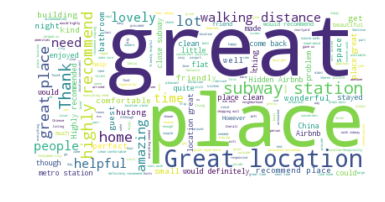

In [474]:
text = " ".join(review for review in reviews_English['cleaned_comments'])
# Create stopword list:
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')
stopwords = set(STOPWORDS)
stopwords.update(["also", "room", "apartment", "posting", "canceled","reservation", "host", "Beijing", "stay",
                 "arrival", "days", "house", "good", "nice", "one", "really", "area", "even"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Is score important?

In [362]:
# first step: clean data and deal with Categorical Variables

In [416]:
response = 'availability_30'
df = listings_detail[['neighbourhood_cleansed', 'room_type', 'price',
                      'review_scores_rating', 'reviews_per_month',
                      'number_of_reviews_ltm', 'property_type',
                        response]]
# df = listings_detail[['room_type', 'price',
#                         'review_scores_rating', 'reviews_per_month',
#                         'availability_365']]

In [417]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34384 entries, 0 to 34383
Data columns (total 8 columns):
neighbourhood_cleansed    34384 non-null object
room_type                 34384 non-null object
price                     34384 non-null object
review_scores_rating      20199 non-null float64
reviews_per_month         20625 non-null float64
number_of_reviews_ltm     34384 non-null int64
property_type             34384 non-null object
availability_30           34384 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 2.1+ MB


In [418]:
df['availability_score'] = np.where(df[response]==0, 30, 30-df[response])
df.drop([response], axis=1, inplace=True)
response = 'availability_score'

/Users/sharonyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/sharonyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [419]:
# df.head()

In [420]:
def currency_to_float(row):
    f = row['price']
    return float(sub(r'[^\d.]', '', f))

df['price_value'] = df.apply(currency_to_float, axis=1)
df.drop(['price'], axis=1, inplace=True)

/Users/sharonyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/sharonyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [421]:
# df['neighbourhood_cleansed'].value_counts()

In [422]:
df['room_type'].value_counts()

Entire home/apt    20855
Private room       11546
Shared room         1983
Name: room_type, dtype: int64

In [431]:
#Dropping where the availability_365 has missing values
df  = df.dropna(subset=[response], axis=0)
print(df.shape)
df.info()

(34384, 8)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 34384 entries, 0 to 34383
Data columns (total 8 columns):
neighbourhood_cleansed    34384 non-null object
room_type                 34384 non-null object
review_scores_rating      20199 non-null float64
reviews_per_month         20625 non-null float64
number_of_reviews_ltm     34384 non-null int64
property_type             34384 non-null object
availability_score        34384 non-null int64
price_value               34384 non-null float64
dtypes: float64(3), int64(2), object(3)
memory usage: 2.4+ MB


In [432]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [433]:
#Pull a list of the column names of the categorical variables
cat_df = df.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns

df_new = create_dummy_df(df, cat_cols_lst, dummy_na=False)

# Show shape to assure it has a shape of (5009, 11938)
print(df_new.shape)

(34384, 63)


In [434]:
df_new = df_new[df_new['price_value']!=0]

In [442]:
# list(df_new)

In [443]:
# Mean function
fill_mean = lambda col: col.fillna(col.mean())
# Fill the mean
fill_df = df_new.apply(fill_mean, axis=0)

#Split into explanatory and response variables
X = fill_df.drop([response], axis=1)
y = fill_df[response]

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=\False) # Instantiate
lm_model.fit(X_train, y_train) #Fit
 
#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

# #Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.3335593431117465.  The rsquared on the test data was -0.23051152116003015.


In [438]:
lm_model.coef_

array([ 7.83695995e-02,  4.82524346e-03,  1.51612323e-01, -6.29873856e-05,
       -5.81072042e+00, -7.67379062e+00, -1.07729459e+01, -8.48177116e+00,
       -1.13013971e+01, -1.01293262e+01, -1.09397216e+01, -8.79864211e+00,
       -3.98712550e+00, -2.08283697e+00, -3.13976859e+00, -5.03580888e-01,
       -9.63658278e+00, -5.32015630e+00, -1.07498945e+01, -1.24309668e+00,
       -4.37326765e+00,  2.39140759e+00, -4.66396700e+00,  3.40373196e+00,
        1.79923320e+00,  1.84763118e+00,  2.20669992e+00,  2.66107123e+00,
        5.66086460e-01, -5.30471900e-01,  1.66748348e+00, -5.80992932e-01,
        2.93788401e+00,  2.82453694e+00,  1.41742993e+00, -1.82935519e+00,
       -7.49401703e-01,  9.22692962e-01,  2.05984027e+00,  1.99651834e+00,
        0.00000000e+00,  5.96283907e+00,  2.78743118e+00,  2.03632154e+00,
       -3.81939967e+00, -1.56865591e+00,  0.00000000e+00, -1.77635684e-15,
        3.84769311e+00,  6.22904678e+00,  4.13096736e+00, -4.02042346e-01,
        1.66457094e+01,  

In [439]:
#step 2: find influence on score

In [440]:
scores = listings_detail[[#'id',
                          'review_scores_rating', 'review_scores_accuracy', 
                          'review_scores_cleanliness', 'review_scores_checkin',
                          'review_scores_communication', 'review_scores_location',
                          'review_scores_value']]
scores.dropna(inplace=True)

/Users/sharonyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


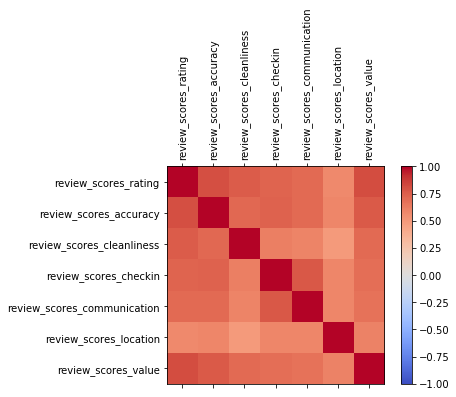

In [414]:
corr = scores.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(scores.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(scores.columns)
ax.set_yticklabels(scores.columns)
plt.show()